## Predicting Customer Churn


### History
Churn is a measurement of the percentage of accounts that cancel or choose not to renew their subscriptions. A high churn rate can negatively impact Monthly Recurring Revenue (MRR) and can also indicate dissatisfaction with a product or service.

Churn is the measure of how many customers stop using a product. This can be measured based on actual usage or failure to renew (when the product is sold using a subscription model). Often evaluated for a specific period of time, there can be a monthly, quarterly, or annual churn rate.

<h3 style="text-align:left;">How is Churn Calculated? </h3>
<p style = "text-align:left;">
In its most simplistic form, the churn rate is the percentage of total customers that stop using/paying over a period of time. So, if there were 10,000 total customers in March and 1,000 of them stopped being customers, the monthly churn rate would be 10%.
</p>
<img src = "https://www.productplan.com/uploads/Churn-Rate-1024x536.png" style="width=500px;height:300px"/>

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict the next leaver.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    ArbitraryNumberImputer)

# for encoding categorical variables
from feature_engine.encoding import OneHotEncoder

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('train.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Churn', axis=1),  # predictors
    data['Churn'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((3955, 20), (989, 20))

In [4]:
# cast target variable to int

data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
# Cast TotalCharges to float

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors = 'coerce')

In [6]:
# drop unnecessary variables

data.drop(labels=['customerID'], axis=1, inplace=True)

## Configuration

In [7]:
# list of variables to be used in the pipeline's transformers

NUMERICAL_VARS_WITH_NA = ['TotalCharges']

CATEGORICAL_VARIABLES = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract', 
                         'DeviceProtection', 'InternetService', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 
                         'PaymentMethod', 'StreamingMovies', 'StreamingTV', 'TechSupport']

FEATURES = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

## Separate data into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Churn', axis=1),  # predictors
    data['Churn'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((3955, 19), (989, 19))

In [9]:
X_train.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

## Pipeline

- Add a binary missing indicator to numerical variables with missing data
- Fill NA in original numerical variable with 0
- Perform One hot encoding
- Scale features with standard scaler
- Fit a Logistic regression

In [10]:
# set up the pipeline
churn_pipe = Pipeline([

    # ===== IMPUTATION =====
    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with 0
    ('zero_imputation', ArbitraryNumberImputer(
        arbitrary_number=0, variables=NUMERICAL_VARS_WITH_NA)),
    
    
    # ===== ENCODING ======
    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),
    
    
    # ===== SCALING ======
    # scale the training data
    ('scaler', StandardScaler()),

    
    # ===== PREDICTION ======
    ('Logit', LogisticRegression(C=0.0005, random_state=0)),
])

In [11]:
# train the pipeline
churn_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['TotalCharges'])),
                ('zero_imputation',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['TotalCharges'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['gender', 'Partner', 'Dependents',
                                          'PhoneService', 'PaperlessBilling',
                                          'Contract', 'DeviceProtection',
                                          'InternetService', 'MultipleLines',
                                          'OnlineBackup', 'OnlineSecurity',
                                          'PaymentMethod', 'StreamingMovies',
                                          'StreamingTV', 'TechSupport'])),
                ('scaler', StandardScaler()),
                ('Logit', LogisticRegression(C=0.0005, rando

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [12]:
# make predictions for train set
class_ = churn_pipe.predict(X_train)
pred = churn_pipe.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = churn_pipe.predict(X_test)
pred = churn_pipe.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8292801445867324
train accuracy: 0.7623261694058154

test roc-auc: 0.8332856924097801
test accuracy: 0.7654196157735086



```
train roc-auc: 0.8292801445867324
train accuracy: 0.7623261694058154

test roc-auc: 0.8332856924097801
test accuracy: 0.7654196157735086
```

In [62]:
# let's plot the predicted sale prices
round(pd.DataFrame(class_).value_counts(normalize=True) * 100, 2)

0    94.54
1     5.46
dtype: float64

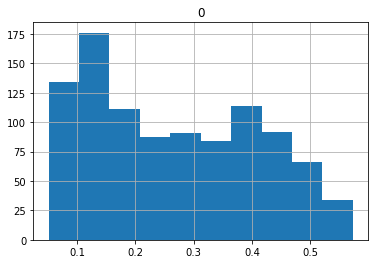

In [61]:
pd.DataFrame(pred).hist();

In [14]:
# now let's save the scaler

joblib.dump(churn_pipe, 'churn_pipe.joblib') 

['churn_pipe.joblib']

# Score new data

In [67]:
# load the unseen / new dataset
data = pd.read_csv('test.csv')

data.drop(labels=['Churn'], axis=1, inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors = 'coerce')

data = data[FEATURES]

print(data.shape)

(2099, 19)


In [68]:
# make predictions for new data
new_preds = churn_pipe.predict(data)
pred_proba = churn_pipe.predict_proba(data)[:,1]

In [69]:
data.join(pd.DataFrame(new_preds, columns=['Prediction'])).join(pd.DataFrame(pred_proba, columns=['Probability'])).head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Prediction,Probability
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.402433
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0.203477
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0.325827


In [70]:
round(pd.DataFrame(new_preds).value_counts(normalize=True) * 100, 2)

0    94.43
1     5.57
dtype: float64

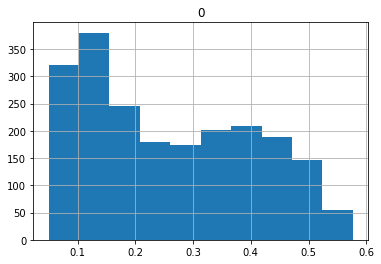

In [71]:
pd.DataFrame(pred_proba).hist();

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**